# Deep Neural Network

## Data Download and Processing

### RUN THE BELOW CELLS IF USING LOCAL MACHINE

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import sys
import os

from sklearn.metrics import classification_report


import bz2, pickle, _pickle as cPickle

import random

# random.seed(1234)

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path+"/Modules/Testing")
# import testing_module

SAVE_DIR = "../Pickled Datasets/"

COPIES = 2
N_DIGITS = 3
HEIGHT = 25
WIDTH  = 25


PLOT_SAVE = "../Plots/loss-curves/"

def compressed_pickle(name: str, data):
    with bz2.BZ2File(os.path.join(SAVE_DIR, "{}.pbz2".format(name)), 'w') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

def plot_history(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    ax[0].plot(epochs, acc, 'r', label = "Training Accuracy")
    ax[0].plot(epochs, val_acc, 'b', label = "Validation Accuracy")
    ax[0].legend()
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel("Epochs")
    
    ax[1].plot(epochs, loss, 'r', label = "Training Loss")
    ax[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
    ax[1].set_title('Training and Validation Losses')
    ax[1].set_xlabel("Epochs")
    plt.show()

    return (fig, ax)


In [4]:
x_train = decompress_pickle(SAVE_DIR + 'x_train.pbz2')
y_train = decompress_pickle(SAVE_DIR + 'y_train.pbz2')
x_val = decompress_pickle(SAVE_DIR + 'x_val.pbz2')
y_val = decompress_pickle(SAVE_DIR + 'y_val.pbz2')
x_test = decompress_pickle(SAVE_DIR + 'x_test.pbz2')
y_test = decompress_pickle(SAVE_DIR + 'y_test.pbz2')

print("train: ", x_train.shape, y_train.shape)
print("val: ", x_val.shape, y_val.shape)
print("test: ", x_test.shape, y_test.shape)

train:  (20601, 25, 25, 3) (20601,)
val:  (2943, 25, 25, 3) (2943,)
test:  (2617, 25, 25, 3) (2617,)


## DNN

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [7]:
# batch sizes
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE  = 32

In [14]:
df = pd.DataFrame(zip(x_train, y_train), columns = ['x', 'y'])

In [21]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range = [-0.2, 0],
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 7.5,
)
test_gen  = DataGenerator(x_val, y_val, VAL_BATCH_SIZE)

# train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# test_ds  = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# train_ds = train_ds.batch(TRAIN_BATCH_SIZE)
# test_ds  = test_ds.batch(TEST_BATCH_SIZE)

gen = train_gen.flow(x = x_train, y = y_train)

Epoch 1/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6703 - accuracy: 0.5848 - val_loss: 0.6676 - val_accuracy: 0.5780
Epoch 2/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6275 - accuracy: 0.6537 - val_loss: 0.8091 - val_accuracy: 0.5019
Epoch 3/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6182 - accuracy: 0.6664 - val_loss: 0.8627 - val_accuracy: 0.5019
Epoch 4/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6159 - accuracy: 0.6705 - val_loss: 0.8022 - val_accuracy: 0.5019
Epoch 5/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6140 - accuracy: 0.6733 - val_loss: 0.8454 - val_accuracy: 0.5019
Epoch 6/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6131 - accuracy: 0.6729 - val_loss: 0.8631 - val_accuracy: 0.5019
Epoch 7/50
644/644 [==============================] - 5s 7ms/step - loss: 0.6106 - accuracy: 0.6742 - val_loss: 0.9224 - val_accuracy: 0.5019
Epoch 

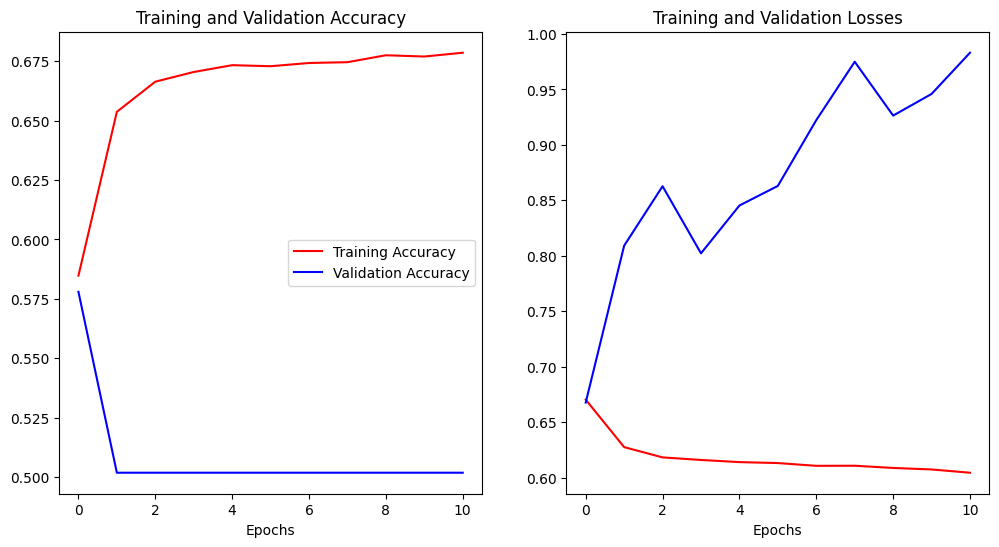

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.848     0.163     0.274     10260
         1.0      0.539     0.971     0.693     10341

    accuracy                          0.569     20601
   macro avg      0.694     0.567     0.483     20601
weighted avg      0.693     0.569     0.484     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.866     0.181     0.299      1466
         1.0      0.545     0.972     0.698      1477

    accuracy                          0.578      2943
   macro avg      0.705     0.577     0.499      2943
weighted avg      0.705     0.578     0.499      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.876     0.169     0.283      1303
         1.0      0.542     0.976     0.697      1314

    accuracy            

In [29]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            gen,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                         tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_TF_AUG")]
        )


cnn.load_weights('CNN_TF_AUG')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "CNN_AUG_TENSORFLOW.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))